# Surface waves on liquid films

We consider the surface wave equations derived by [Gjevik](https://doi.org/10.1063/1.1693186)

$$
\begin{equation}
\frac{\partial \eta}{\partial t} + 2\left(\frac{\partial \eta}{\partial x} + \frac{\partial \eta^2}{\partial x} \right)+\alpha \left(B_1 \frac{\partial^2 \eta}{\partial x^2}+C_1\frac{\partial^4 \eta}{\partial x^4}\right) = 0. \label{eq:eta}
\end{equation}
$$
Here the surface elevation is given as $\eta(x, t)$, whereas $\alpha, B_1$ and $C_1$ are constants dependent on the liquid height, $h_0$, angle of the surface with the vector of gravity acceleration, $\theta$, wave length, $\lambda$, the Reynolds and Weber numbers. 

$$
\begin{align}
\alpha &= \frac{2 \pi h_0}{\lambda} \\
B_1 &= \frac{8}{15} \text{Re} - \frac{2}{3\tan \theta} \\
C_1 &= \frac{2}{3} \alpha^2 \text{We}
\end{align}
$$

We assume that the solution is periodic in the $x$-direction and solve the nonlinear equation using a Fourier discretization in space, and a [fourth order Exponential Runge-Kutta method in time](https://arxiv.org/pdf/1604.08900.pd). 

A Fourier expansion of the solution is given as

$$
\begin{equation}
\eta(x, t) = \sum_{k=-N/2}^{N/2-1} \hat{\eta}_k(t) e^{\imath k x}, \label{eq:etaexpansion}
\end{equation}
$$
where $\{\hat{\eta}_k\}_{k=-N/2}^{N/2-1}$ are the Fourier expansion coefficients, and $e^{\imath k x}$ are the basis functions that we expand the solution in. Note that the expansion coefficients depend on time, but not on space.

The initial solution is set to

$$
\eta(x, 0) = h_0 e^{\imath x}.
$$

That is, we start with only one nonzero Fourier coefficient, $\hat{\eta}_1=h_0$.

With a spectral Galerkin method the governing equation can be transformed into an equation for the coefficients $\{\hat{\eta}_k\}$. This corresponds to taking a forward Fourier transform of Eq. \eqref{eq:eta}, something that is achieved by multiplying \eqref{eq:eta} by the test function $e^{-\imath m x}$ and integrating over the domain, which is set to $[0, 2\pi]$

$$
\begin{equation}
\int_{0}^{2\pi}\left\{\frac{\partial \eta}{\partial t} + 2\left(\frac{\partial \eta}{\partial x} + \frac{\partial \eta^2}{\partial x} \right)+\alpha \left(B_1 \frac{\partial^2 \eta}{\partial x^2}+C_1\frac{\partial^4 \eta}{\partial x^4}\right) \right\} e^{-\imath m x} dx =0 \label{eq:etatransform}
\end{equation}
$$

Insert for $\eta$ using \eqref{eq:etaexpansion} to obtain

$$
\begin{equation}
\int_{0}^{2\pi}\left\{\frac{\partial}{\partial t}\sum_{k} \hat{\eta}_k(t) e^{\imath k x} + 2 \frac{\partial}{\partial x} \left( \sum_{k} \hat{\eta}_k(t) e^{\imath k x} + \eta^2 \right)+\alpha \left(B_1 \frac{\partial^2 }{\partial x^2} \sum_{k} \hat{\eta}_k(t) e^{\imath k x}+C_1\frac{\partial^4}{\partial x^4} \sum_{k} \hat{\eta}_k(t) e^{\imath k x} \right) \right\} e^{-\imath m x} dx  = 0. \label{eq:etatransform2}
\end{equation}
$$

Note that we do not insert for $\eta$ in the nonlinear term. This is because the nonlinearity needs to be computed with a pseudospectral method, and this will be described below. All linear terms transform trivially due to orthogonality of the exponential functions, i.e., only integrals with $k=m$ are nonzero, leading to 

$$
\begin{equation}
\frac{\partial \hat{\eta}_k}{\partial t} + 2 \imath k \hat{\eta^2}_k + \left( 2 \imath k + \alpha (-B_1 k^2 + C_1 k^4) \right) \hat{\eta}_k = 0. \label{eq:etatransform3}
\end{equation}
$$

The nonlinear term is computed with dealiasing by first transforming $\{\hat{\eta}_k\}$ to the physical mesh $x_j = 2 \pi j / M$, where $M = 3N/2$. Compute the nonlinearity on the physical mesh and then forward transform the nonlinear product with truncation of wavenumbers larger than $N$. The result is here called $\{\hat{\eta^2}_k\}$. 

The seminonlinear equation is solved using an exponental Runge-Kutta integrator, see [Montanelli and Bootland](https://arxiv.org/pdf/1604.08900.pdf). 

To solve the equations numerically we will use the [shenfun](https://github.org/spectralDNS/shenfun) spectral Galerkin computational framework. Below is a complete solver, where it should be trivial to manipulate parameters and set up the solver. A jupyter notebook of this solver is found [here](https://github.org/mikaem/surface-waves-on-liquid-films/surfacewaves.ipynb)

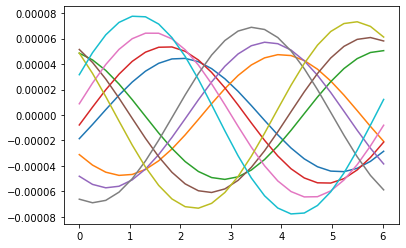

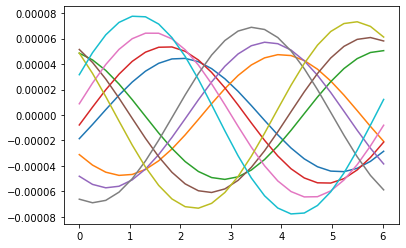

In [1]:
from shenfun import *
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

N = 24
T = Basis(N, 'F', dtype='D') # Using complex initial data
Tp = Basis(N, 'F', dtype='D', padding_factor=1.5)
x = T.mesh()
u = TrialFunction(T)
v = TestFunction(T)
k = T.wavenumbers(scaled=True, eliminate_highest_freq=True)

# Choose papameters
Re = 5.0
We = 755.
theta = np.pi/2.
h0 = 0.000042
lmbda = 0.0098
alpha = 2*np.pi*h0/lmbda
B_1 = 8./15.*Re-2./3./np.tan(theta)
C_1 = 2./3.*alpha**2*We

# Arrays to hold the solution
eta_ = Array(T)
etap = Array(Tp)      # For the nonlinear part
eta_hat = Function(T)

# Initialize
eta_hat[1] = h0

# The integrator needs one function to compute the linear part, 
# and one term for the nonlinear.
def LinearRHS(self, **params):
    """Return linear operator for right hand side."""
    L = -2*1j*k - alpha*(-B_1*k**2 + C_1*k**4)
    return L

def NonlinearRHS(self, eta, eta_hat, rhs, **params):
    """Return nonlinear part of right hand side."""
    rhs.fill(0)
    etap[:] = Tp.backward(eta_hat, etap)
    rhs = Tp.forward(-2*etap**2, rhs)
    rhs *= 1j*k
    return rhs

data = []
def update(self, eta, eta_hat, t, tstep, plot_step, fig, **par):
    """Function called at the end of each time step."""
    if tstep % plot_step == 0 and plot_step > 0:
        eta = eta_hat.backward(eta)
        fig.gca().plot(x, eta)
        display.clear_output(wait=True)
        display.display(fig)
        data.append(eta_hat.copy())

# Specify time step size and end time. 
dt = 0.001
end_time = 10.
par = {'plot_step': 1000, 'fig': plt.figure(1)}
integrator = ETDRK4(T, L=LinearRHS, N=NonlinearRHS, update=update, **par)
integrator.setup(dt)
eta_hat = integrator.solve(eta_, eta_hat, dt, (0, end_time))